# Add Folders to Path

In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-2])

# add Algorithm folder to current working path in order to access the functions
sys.path.append(parent_directory+"/Src")

CPU times: user 126 µs, sys: 108 µs, total: 234 µs
Wall time: 208 µs


In [2]:
# Suppress numba warnings arising from computation falling back into object mode.
from numba.core.errors import NumbaDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)

# Overview

In the following notebok we extract hyperbolic (attracting/repelling) LCS in the Agulhas region from the AVISO dataset. The notebook is structured as follows:

* Import data from the file 'Agulhas_AVISO.mat' stored in the folder 'Data'
* Define computational parameters (such as the number of cores) and variables
* Define spatio-temporal domain over which to compute the hyperbolic LCS. The spatial domain defines the meshgrid from where to launch the trajectories and the temporal domain specifies the time-interval (in days).
* Interpolate velocity from the gridded data using a cubic spline interpolation
* Compute Cauchy Green strain tensor over meshgrid of initial conditions over the specified time-interval
* Compute repelling LCS (shrinklines) at initial time
* Compute attracting LCS (stretchlines) at initial time

# Import data

In [3]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../Data/Agulhas_AVISO.mat')

U = mat_file['u']
V = mat_file['v']
x = mat_file['x']
y = mat_file['y']
time = mat_file['t']

CPU times: user 16.3 ms, sys: 10.8 ms, total: 27.2 ms
Wall time: 26.3 ms


# Data/Parameters for dynamical system

In [4]:
import numpy as np

# number of cores to be used for parallel computing
Ncores = 40

# periodic boundary conditions
periodic_x = False
periodic_y = False
Periodic = [periodic_x, periodic_y]

## compute meshgrid of dataset
X, Y = np.meshgrid(x, y)

# list of parameters
params_data = {"X": X, "Y": Y, "Time": time, "U": U, "V": V, "Ncores": Ncores, "Periodic": Periodic}

<a id='Spatio-Temporal-Domain-of-Dynamical-System'></a>
# Spatio-temporal domain of dynamical system

In [5]:
%%time
# Initial time (in days)
t0 = 0

# Final time (in days)
tN = 30

# time step-size
dt = .1

time = np.arange(t0, tN+dt, dt)

# domain boundaries (in degrees)
xmin = -3
xmax = 1
ymin = -32
ymax = -24

# spacing of meshgrid (in degrees)
dx = 0.02
dy = 0.02

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

# meshgrid of domain
X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

# Define parameters
params_DS = {"time": time, "X_domain": X_domain, "Y_domain": Y_domain}

# Initialize Dynamical System
from ipynb.fs.defs.DynamicalSystem import *

DS = Dynamical_System(params_data, params_DS)

CPU times: user 106 ms, sys: 32.2 ms, total: 138 ms
Wall time: 137 ms


# Interpolate Velocity

In order to evaluate the velocity field at arbitrary locations and times, we must interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". In order to favour a smooth velocity field, we interpolate the velocity field in space using a cubic interpolant.

In [6]:
%%time
# Interpolate velocity data using cubic spatial interpolation
DS._Interpolation_velocity("cubic")

CPU times: user 85.5 ms, sys: 5.98 ms, total: 91.5 ms
Wall time: 90.4 ms


# Cauchy Green (CG) strain tensor over meshgrid of initial conditions

The rate of strain tensor $ S(\mathbf{x}, t) $ at time $ t $ is computed by iterating over meshgrid. The method *DS._spin_tensor(x, t)* computes the rate of strain tensor at point $ \mathbf{x} $  at time $ t $ by using an auxiliary meshgrid. 'aux_grid' specifies the ratio between the auxiliary grid and the original meshgrid. This parameter is generally chosen to be between $ [\dfrac{1}{20}, \dfrac{1}{100}] $. The computations are parallelized.

In [7]:
%%time
# Import function to calculate Cauchy Green (CG) strain tensor from gradient of Flow map
from ipynb.fs.defs.CauchyGreen import _CauchyGreen

# tqdm is used to display progress bar
from tqdm.notebook import tqdm

# joblib is used for parallel computing
from joblib import Parallel, delayed

# Define ratio of auxiliary grid vs original meshgrid
aux_grid = 0.1

def parallel(i):
    
    # Define CG tensor
    C_ = np.zeros((X_domain.shape[1], 2, 2))
    
    # Iterate over initial conditions
    for j in range(X_domain.shape[1]):
        
        # Point at which to calculate CG tensor
        x = np.array([X_domain[i, j], Y_domain[i, j]])
        
        # Calculate gradient of flow map at 'x' over the time-interval 'time' using an auxiliary grid ratio 'aux_grid'
        grad_Fmap = DS._grad_Fmap(x, time, aux_grid)
        
        C_[j, :, :] = _CauchyGreen(grad_Fmap)
        
    return C_

C = np.array(Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel)(i) for i in tqdm(range(X_domain.shape[0]))))

  0%|          | 0/401 [00:00<?, ?it/s]

CPU times: user 32.5 s, sys: 8.33 s, total: 40.8 s
Wall time: 8min 47s


# Shrinklines (Repelling LCS)

Repelling LCS can be sought among trajectories of the differential equation:

\begin{equation}
\mathbf{x}'_0(s) = \xi_1(\mathbf{x}_0;t_0, t_N),
\label{eq: shrinklines}
\end{equation}

with $ \xi_1 $ denoting the eigenvector associated to the weakest eigenvalue $ \lambda_1 $ of $ C_{t_0}^{t_N}(\mathbf{x}_0) $. The non-orientable vector field is well defiend away from tensorline singularites (points where $ \lambda_1 = \lambda_2 $).
The most repelling shrinklines mark initial positions of repelling LCSs. Repelling LCSs can therefore be located as trajectories of eq. \ref{eq: shrinklines} that have locally the largest averaged $ \lambda_2(\mathbf{x}_0;t_0, t_N) $ among all neighbouring shrinklines.

In [8]:
from ipynb.fs.defs.shrinklines import _shrinklines

# step-size used for integration with respect to parameter 's'
step_size = 0.02

# threshold distance to locate local maxima in the 'lambda_2' field of 'C'
max_distance = 0.2

# maximum length of shrinkline
max_length = 5

# compute shrinklines
shrinklines = _shrinklines(X_domain, Y_domain, C, max_distance, max_length, step_size)

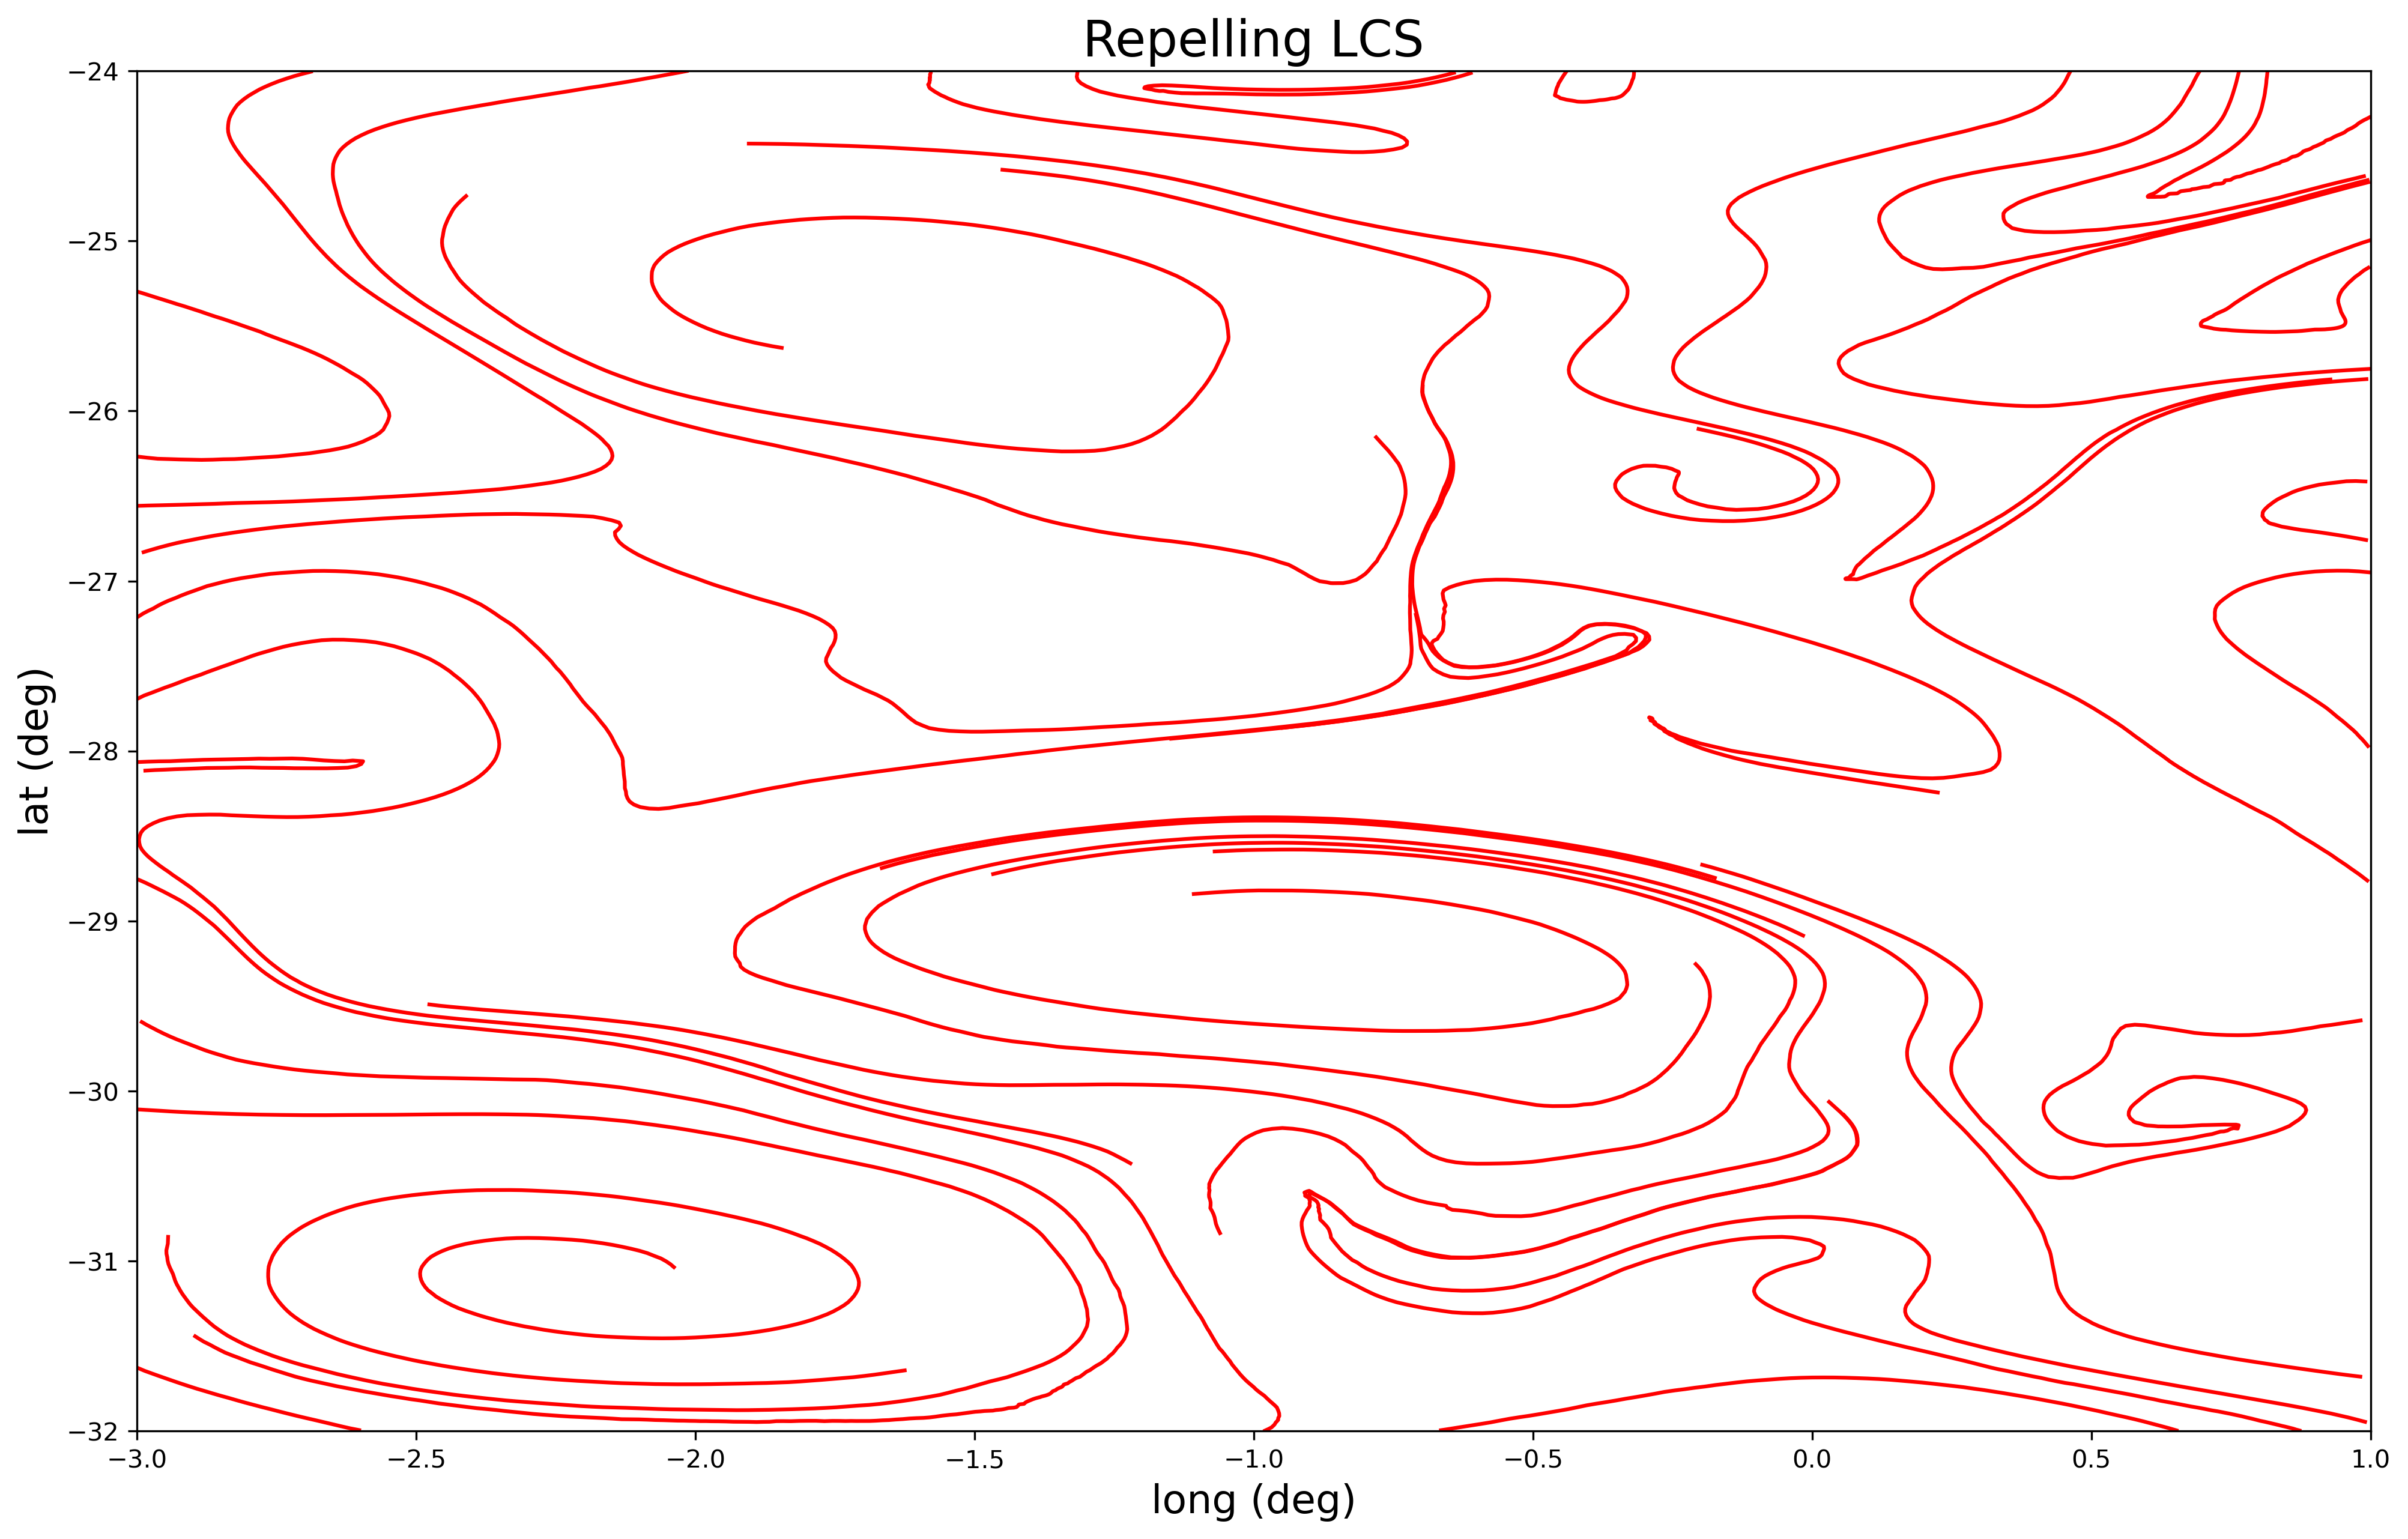

In [9]:
###################################### PLOT REPELLING LCS ######################################

# import plotting library
import matplotlib.pyplot as plt
import matplotlib as mpl

# Define figure/axes
fig = plt.figure(figsize = (16, 10), dpi = 300)
ax = plt.axes()

for i in range(len(shrinklines[0])):
    ax.plot(shrinklines[0][i], shrinklines[1][i], c = 'r')
    
# Set axis limits
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

# Set axis labels
ax.set_xlabel("long (deg)", fontsize = 16)
ax.set_ylabel("lat (deg)", fontsize = 16)

# Colorbar
#cbar = fig.colorbar(cmap, ticks=[mu_range.min(), 0, mu_range.max()])
#cbar.ax.set_ylabel(r'$ \mu $', rotation = 0, fontsize = 16)

# Title
ax.set_title("Repelling LCS", fontsize = 20)
plt.show();

# Stretchlines (Attracting LCS)

Attracting LCS can be sought among trajectories of the differential equation:

\begin{equation}
\mathbf{x}'_0 = \xi_2(\mathbf{x}_0;t_0, t_N),
\label{eq: stretchlines}
\end{equation}

with $ \xi_2 $ denoting the eigenvector associated to the strongest eigenvalue $ \lambda_2 $ of $ C_{t_0}^{t_N}(\mathbf{x}_0) $. The non-orientable vector field is well defiend away from tensorline singularites (points where $ \lambda_1 = \lambda_2 $).
The most attracting stretchlines mark initial positions of attracting LCSs. Attracting LCSs can therefore be located as trajectories of eq. \ref{eq: stretchlines} that have locally the smallest averaged $ \lambda_1(\mathbf{x}_0;t_0, t_N) $ among all neighbouring stretchlines.

In [10]:
from ipynb.fs.defs.stretchlines import _stretchlines

# step-size used for integration with respect to parameter 's'
step_size = 0.02

# threshold distance to locate local minima in the 'lambda_1' field of 'C'
max_distance = 0.2

# maximum length of stretchline
max_length = 5

# compute stretchlines
stretchlines = _stretchlines(X_domain, Y_domain, C, max_distance, max_length, step_size)

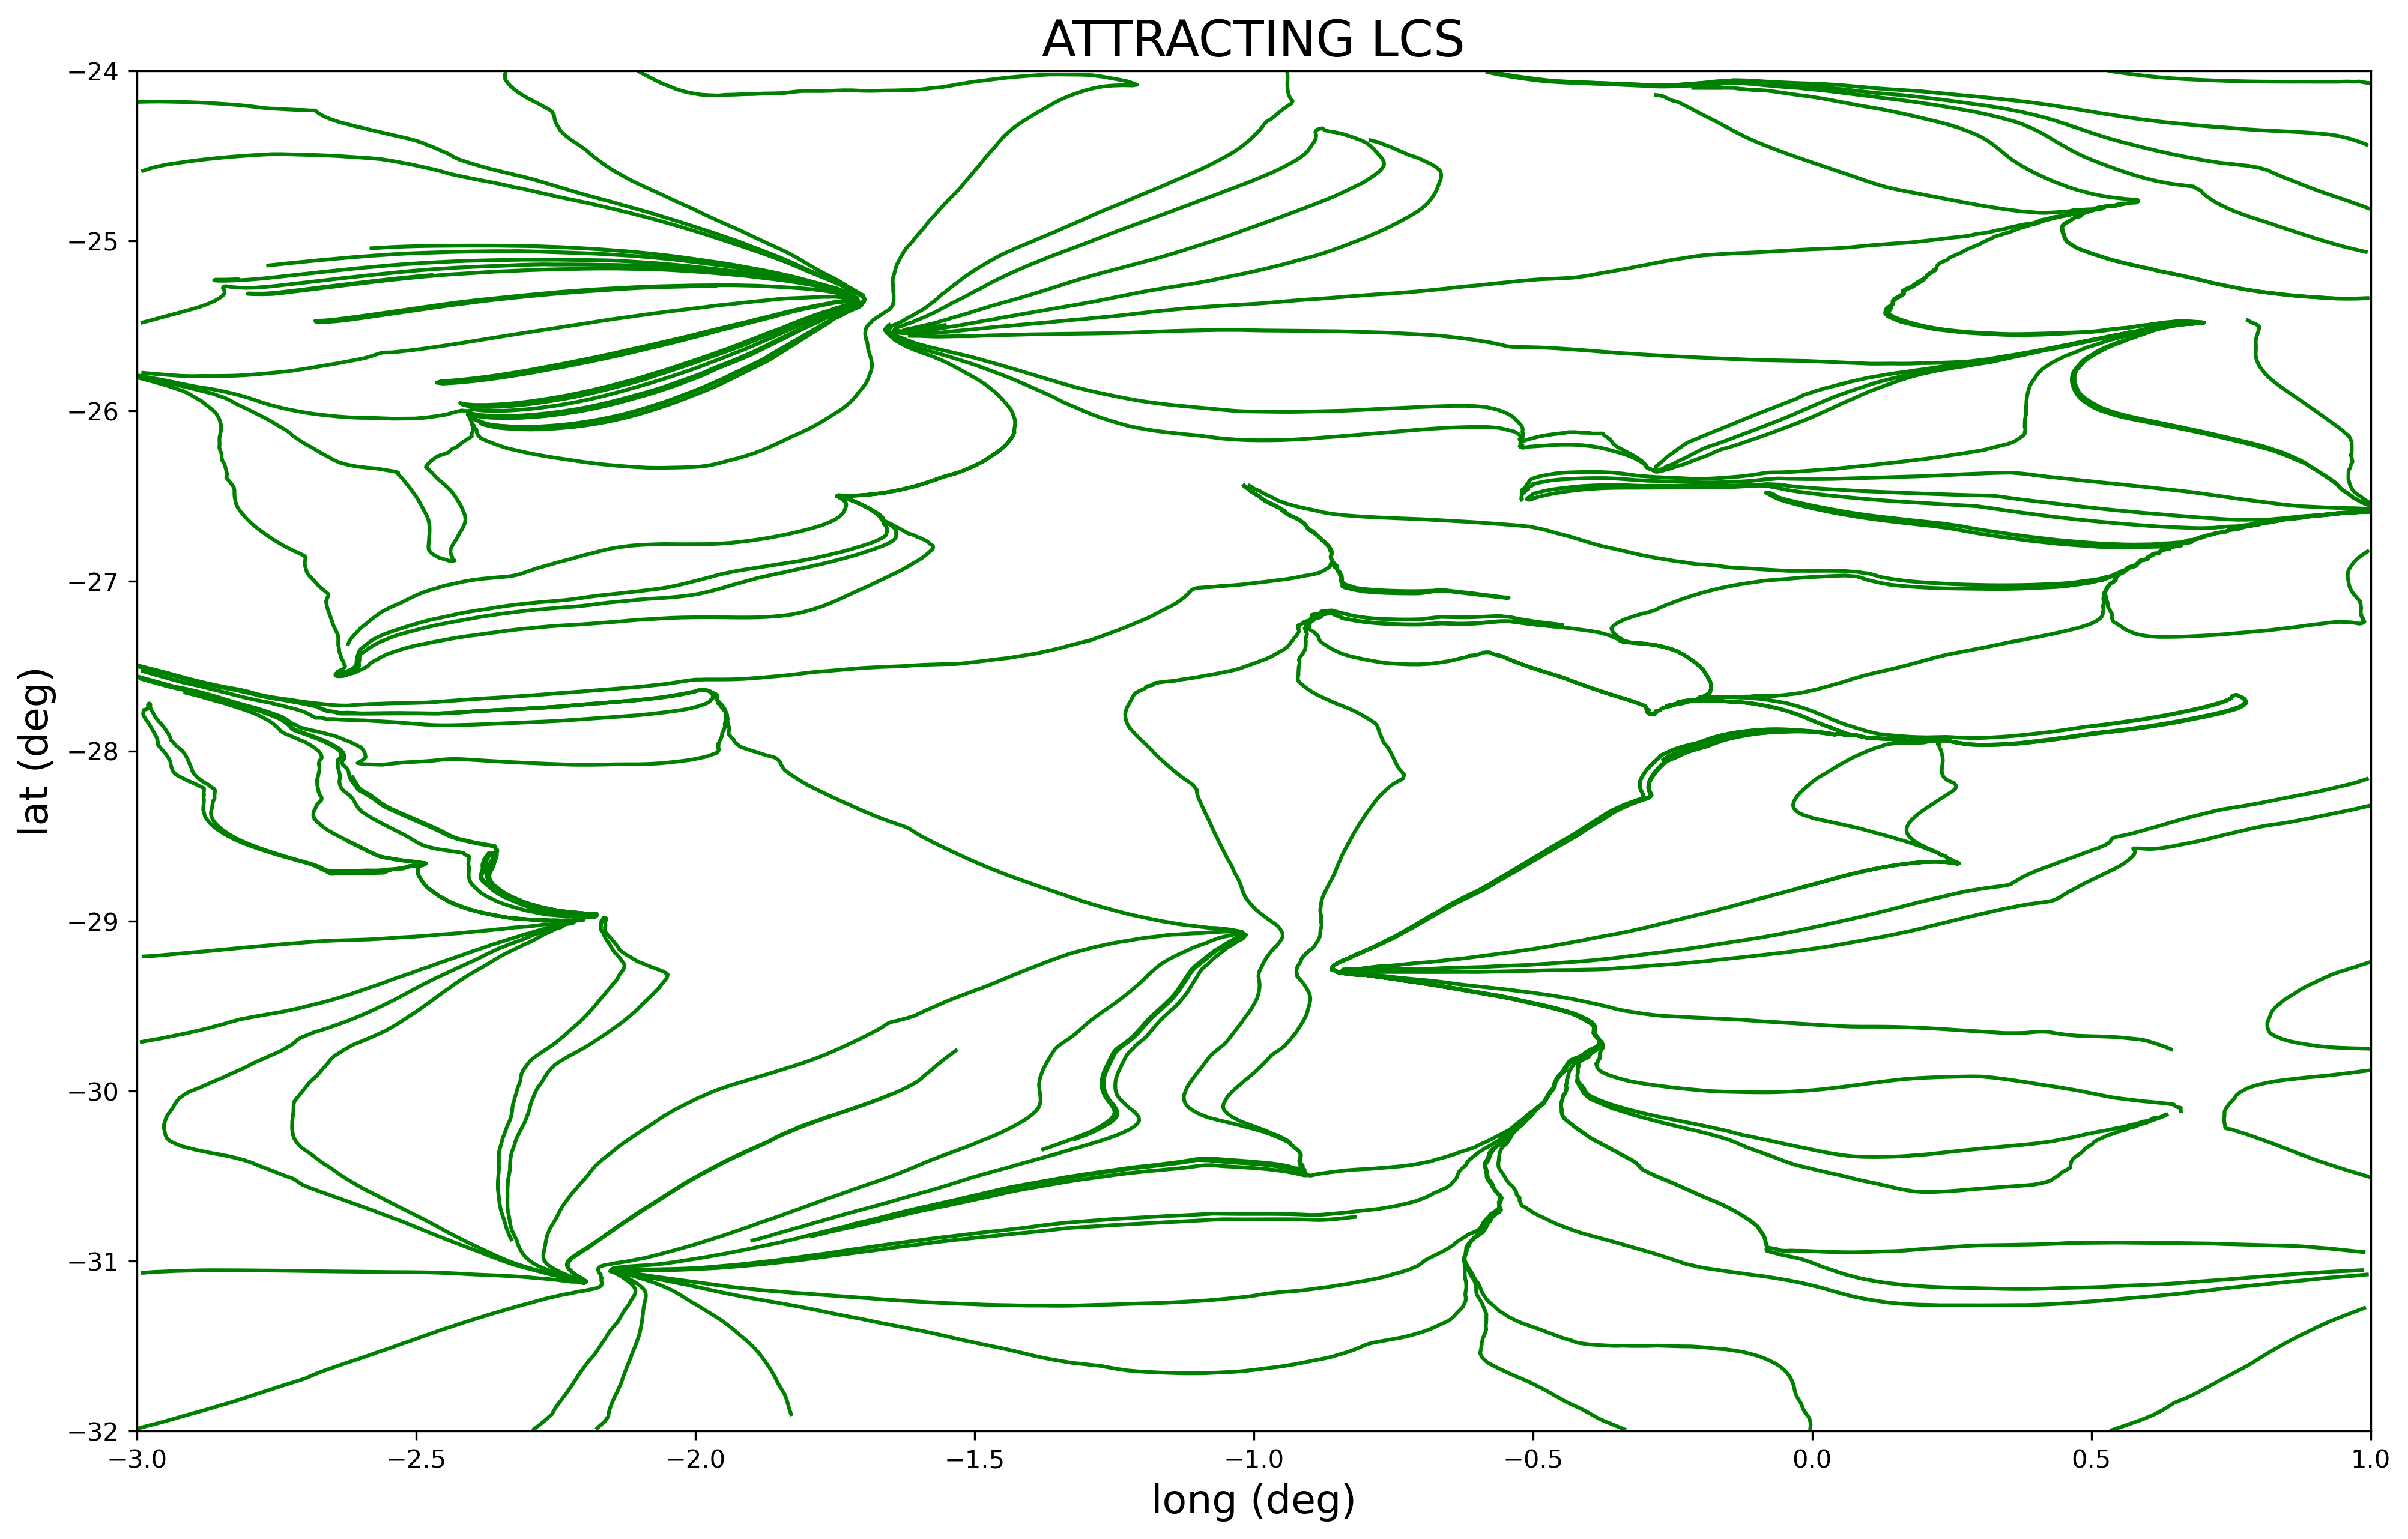

In [13]:
###################################### PLOT ATTRACTING LCS ######################################

# Define figure/axes
fig = plt.figure(figsize = (16, 10), dpi = 300)
ax = plt.axes()

for i in range(len(stretchlines[0])):
    ax.plot(stretchlines[0][i], stretchlines[1][i], c = 'g')
    
# Set axis limits
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

# Set axis labels
ax.set_xlabel("long (deg)", fontsize = 16)
ax.set_ylabel("lat (deg)", fontsize = 16)

# Colorbar
#cbar = fig.colorbar(cmap, ticks=[mu_range.min(), 0, mu_range.max()])
#cbar.ax.set_ylabel(r'$ \m $', rotation = 0, fontsize = 16)

# Title
ax.set_title("ATTRACTING LCS", fontsize = 20)
plt.show();